In [2]:
import pandas as pd
import numpy as np

from preprocessing.logParser import openLogs
from content.video import Video

In [3]:
cursor = openLogs('logs/spbu_ACADRU_spring_2018-TL')

In [5]:
def get_videos_pages():
    """get the set of pages y load_video event"""
    
    request = """
            select *
            from load_video
            """
    cursor.execute(request)
    data = cursor.fetchall()
    
    columns_names = []
    for i in cursor.description[:]:
        columns_names.append(i[0])
    
    df = pd.DataFrame(data=data, columns=columns_names)
    
    pages = set()
    for page in df.page:
        pages.add(page)
    return pages

In [6]:
def check_video(page):
    video_events = ["hide_transcript", "pause_video",
                    "play_video", "seek_video",
                    "show_transcript", "speed_change_video", "stop_video",
                    "video_hide_cc_menu", "video_show_cc_menu"]

    for i in video_events:
        request = """
                    select *
                    from {}
                    where page = "{}"
                    """.format(i, page)
        cursor.execute(request)
        data = cursor.fetchall()
        if data : return True
    return False

# Video review

In [30]:
def get_video_review():
    videos = []
    for page in get_videos_pages():    
        # get length by stop_video event
        request = """
                select max(video_time)
                from stop_video
                where page = "{}"
                """.format(page)
        cursor.execute(request)
        length = cursor.fetchall()[0]
        length = length[0]
        if length == None:  
            # todo: make handler
            pass
        else:
            # todo: intervals_number
            intervals_number = 50
            review_intervals = np.zeros(shape=(intervals_number,))
            step = length / intervals_number

            request = """
                    select video_old_time, video_new_time
                    from seek_video
                    where page = "{}"
                    """.format(page)
            cursor.execute(request)
            for video_old_time, video_new_time in cursor.fetchall():
                begin = int(video_new_time / step)
                end = int(video_old_time / step) + 1
                for i in range(begin, end):
                    review_intervals[i] += 1

            video = Video(page, length, intervals_number, review_intervals)
            videos.append(video)
    return videos

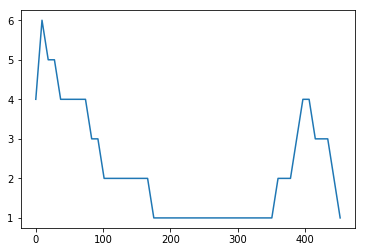

In [31]:
import matplotlib.pyplot as plt

videos = get_video_review()
video = videos[8]
plt.plot(np.linspace(0, video.length, video.intervals_number), video.review_intervals)
plt.show()

# What part of video was watched

In [ ]:
for video in videos:
    request = """
                select video_old_time, video_new_time
                from seek_video
                where page = "{}"
                """.format(video.page)
    cursor.execute(request)
    data = cursor.fetchall()
    